## Linear Regression Models and Regularization

In this notebook, we go over Linear Regression methods (with and without regularization: LinearRegression, Ridge, Lasso, ElasticNet) to predict the __log_votes__ field of our Amazon Product Review dataset. 

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Training and test datasets</a>
5. <a href="#5">Data processing using Bag of Words</a>
6. <a href="#6">Train a regressor</a>
7. <a href="#7">Test the regressor</a>
8. <a href="#8">Improvement ideas</a>



*Find more details on the classical Linear Regression models with and without regularization [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).*

__Amazon Product Review Dataset__:

In this exercise, we are working with a product review dataset from Amazon. The raw data is available [here](https://nijianmo.github.io/amazon/index.html). You can find this dataset under `DATA/product-reviews`: Amazon_Reviews_Regression.csv and Amazon_Reviews_Classification.csv.

__Dataset schema:__ 
* __reviewText__ - Text of the review
* __summary__ - Summary of the review
* __verified__ - Whether the purchase was verified (True or False)
* __time__ - UNIX timestamp for the review
* __rating__ - Rating of the review
* __log_votes__ - Logarithm-adjusted votes log(1+votes). This is the field to predict.


## 1. Read the dataset
(<a href="#0">Go to top</a>)

We will use the Pandas library to read our dataset.

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

import pandas as pd

df = pd.read_csv('../../DATA/product-reviews/Amazon_Reviews_Regression.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55000, 6)


Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [2]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


## 2. Exploratory Data Analysis
(<a href="#0">Go to top</a>)

Let's look at the distribtion of the only numerical feature in the dataset (rating).

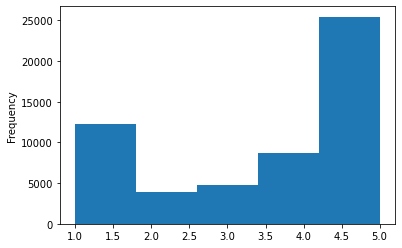

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
df['rating'].plot.hist(bins=5)
plt.show()

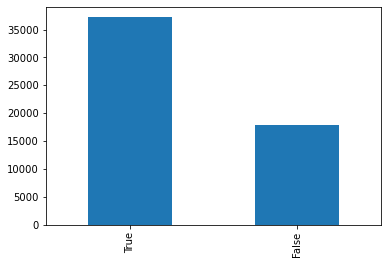

In [4]:
df['verified'].value_counts().plot.bar()
plt.show()

#### Target distribution

Let's check our target distribution.

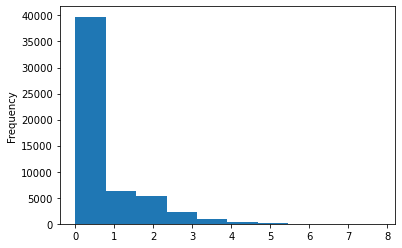

In [5]:
df['log_votes'].plot.hist(bins=10)
plt.show()

Let's look at the range and distribution of log_votes

In [6]:
df["log_votes"].min()

0.0

In [7]:
df["log_votes"].max()

7.799753318287247

#### Missing values
We can check the number of missing values for each columm below.

In [8]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


### Imputation
Let's fill-in the missing values for __reviewText__ below. We will just use the placeholder "Missing" here. We will focus on the __reviewText__ column and drop the __summary__ column later, so there is no need to fill the missing values for __summary__.

In [9]:
df["reviewText"].fillna("Missing", inplace=True)

## 3. Selecting features to build the model
(<a href="#0">Go to top</a>)

In this particular dataset, there are 2 text based columns which we want to prepare to use and 1 categorical and 1 numerical column each. For now, we ignore the __time__ column and as mentioned previously we also drop __summary__.

In [10]:
df.drop('time', axis = 1, inplace = True)
df.drop('summary', axis = 1, inplace = True)

#### Cleaning text features 

Text cleaning can be performed here, before train/test split, with less code. The cleaning should happen after stop words have been removed as there will be fewer words to process.

In [11]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [12]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [13]:
df["reviewText"] = process_text(df["reviewText"].tolist()) 

In [14]:
df['verified'] = df['verified'].astype(str)

## 4. Training and test datasets
(<a href="#0">Go to top</a>)

Sklearn library has a useful function to split datasets. We will use the `train_test_split()` function. In the example below, we get 90% of the data for training and 10% is left for validation.

In [15]:
from sklearn.model_selection import train_test_split

# Input: "reviewText", "rating" and "verified"
# Target: "log_votes"
X_train, X_test, y_train, y_test = train_test_split(df[["reviewText", "rating", "verified"]],
                                                  df["log_votes"].tolist(),
                                                  test_size=0.10,
                                                  shuffle=True
                                                 )

## 5. Data processing using Bag of Words (BoW)
(<a href="#0">Go to top</a>)

We are using binary features here. TF and TF-IDF are other options.

In [48]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler()) 
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) 
                                ])
# Preprocess 1st text feature
text_processor = Pipeline([
    ('text_vect', CountVectorizer(binary=False, max_features=50))
                                ])


# Combine all data preprocessors from above
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, ['rating']),
    ('categorical_pre', categorical_processor, ['verified']),
    ('text_pre', text_processor, ['reviewText'][0]),
                                    ]) 

## 6. Train a regressor
(<a href="#0">Go to top</a>)

### 6.1  LinearRegression
Let's first fit __LinearRegression__ from Sklearn library, and check the performance on the validation dataset. Using the __coef___ atribute, we can also print the learned weights of the model.

Find more details on __LinearRegression__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [49]:
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LinearRegression

### PIPELINE ###
################

lr_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lrRegressor', LinearRegression())
                    ])

In [50]:
# Train the model
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['rating']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=50))]),
                                                  'reviewText')])),
                ('lrRegressor', LinearRegression())])

In [51]:
print("LinearRegression model weights: \n", lr_pipeline[-1].coef_)

LinearRegression model weights: 
 [-0.37395732  0.22501447 -0.22501447  0.058752   -0.00195342  0.06254532
 -0.01508338 -0.02295556 -0.00351443  0.04693709 -0.0048084   0.05294852
 -0.02567536  0.04125754  0.00504168  0.02704792  0.01950597  0.01226088
 -0.00091259  0.05450059  0.07248126  0.03943284  0.02413407  0.04189922
  0.03132283  0.02866759  0.007512    0.05565781  0.05843321  0.06883673
 -0.01573512  0.03887425  0.00658408  0.04506194  0.0404797   0.03166256
 -0.03536822  0.02146245  0.00633346  0.02253465 -0.00371238  0.05152897
 -0.01324726  0.01901319  0.06543954  0.01733524  0.05137724  0.05791584
  0.01750658 -0.00686233 -0.01510776 -0.00374756  0.02259369]


### 6.2  Ridge (Linear Regression with L2 regularization)
Let's now fit __Ridge__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __Ridge__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

To improve the performance of a LinearRegression model, __Ridge__ is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization. 


In [52]:
from sklearn.linear_model import Ridge

### PIPELINE ###
################

r_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('ridgeRegressor', Ridge(alpha = 100))
                    ])

In [53]:
# Train the model
r_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['rating']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=50))]),
                                                  'reviewText')])),
                ('ridgeRegressor', Ridge(alpha=100))])

In [54]:
print("RidgeRegression model weights: \n", r_pipeline[-1].coef_)

RidgeRegression model weights: 
 [-0.36755327  0.22420725 -0.22420725  0.05859136 -0.00128551  0.06362876
 -0.01470638 -0.02272083 -0.00427955  0.04519285 -0.00476829  0.05260997
 -0.02565603  0.04143749  0.0047034   0.02614767  0.01973315  0.01263284
 -0.00102694  0.05396426  0.07250973  0.03851613  0.02335026  0.04123801
  0.03170989  0.02854488  0.00843556  0.05537407  0.0582881   0.06935947
 -0.01547788  0.03942392  0.00677962  0.04509613  0.04058778  0.03215514
 -0.03520449  0.02210827  0.00677873  0.02261013 -0.00320267  0.05108282
 -0.01324224  0.01911625  0.06545858  0.01758704  0.0507683   0.05822591
  0.01600529 -0.00682365 -0.01480653 -0.00338166  0.02240755]


#### 6.3 LASSO (Linear Regression with L1 regularization)
Let's also fit __Lasso__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __Lasso__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

__Lasso__ is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$. 

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with __Lasso__, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [55]:
from sklearn.linear_model import Lasso

### PIPELINE ###
################

l_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('ridgeRegressor', Lasso(alpha = 0.001))
                    ])

In [56]:
# Train the model
l_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['rating']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=50))]),
                                                  'reviewText')])),
                ('ridgeRegressor', Lasso(alpha=0.001))])

In [57]:
print("LassoRegression model weights: \n", l_pipeline[-1].coef_)

LassoRegression model weights: 
 [-0.36384622  0.44930082 -0.          0.05570958 -0.          0.05884411
 -0.01152351 -0.0150697  -0.          0.04022096 -0.          0.05054691
 -0.02254984  0.04122417  0.00227151  0.02234159  0.01637584  0.01102972
  0.          0.0529883   0.06872393  0.03516945  0.02167352  0.04002512
  0.03187947  0.02842942  0.00423069  0.05600899  0.05840672  0.06436108
 -0.01362938  0.03609964  0.00307643  0.04555458  0.03873517  0.02847008
 -0.03257884  0.01715813  0.00549896  0.01932366 -0.          0.04915628
 -0.0095832   0.01687975  0.06280108  0.01705427  0.04937569  0.05354474
  0.01258378 -0.00435497 -0.01115829 -0.          0.01992463]


#### 6.4 ElasticNet (Linear Regression with L2 and L1 regularization)
Let's finally try __ElasticNet__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __ElasticNet__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

__ElasticNet__ is tuning model complexity by adding both $L_2$ and $L_1$ penalty scores for complexity to the model's cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  0.5*alpha∗(1-\textit{l1}_{ratio})||\textbf{w}||_2^2 + alpha∗\textit{l1}_{ratio}∗||\textbf{w}||_1$$

and using two parameters, $alpha$ and $\textit{l1}_{ratio}$, to control the strength of the regularization.

In [58]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

### PIPELINE ###
################

en_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('ridgeRegressor', ElasticNet(alpha = 0.001, l1_ratio = 0.1))
                    ])

In [59]:
# Train the model
en_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['rating']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=50))]),
                                                  'reviewText')])),
                ('ridgeRegressor', ElasticNet(alpha=0.001, l1_ratio=0.1))])

In [60]:
print("ElasticNetRegression model weights: \n", en_pipeline[-1].coef_)

ElasticNetRegression model weights: 
 [-3.70375480e-01  2.29102296e-01 -2.20189901e-01  5.80869432e-02
 -9.74278756e-04  6.20715061e-02 -1.46864357e-02 -2.19445104e-02
 -3.06018616e-03  4.57318272e-02 -3.65824383e-03  5.25206555e-02
 -2.53254125e-02  4.12193549e-02  4.63843537e-03  2.61460520e-02
  1.91355676e-02  1.21110670e-02 -2.18410982e-04  5.41949082e-02
  7.17056884e-02  3.87074243e-02  2.37350019e-02  4.16157908e-02
  3.15551696e-02  2.86125830e-02  7.16616223e-03  5.57446701e-02
  5.84397077e-02  6.81684144e-02 -1.54853142e-02  3.83468119e-02
  6.24660295e-03  4.51609521e-02  4.04053602e-02  3.12494521e-02
 -3.50377422e-02  2.08533519e-02  6.31168187e-03  2.22947861e-02
 -3.20824318e-03  5.11740399e-02 -1.28506489e-02  1.88608828e-02
  6.49113847e-02  1.73302400e-02  5.10012833e-02  5.71689059e-02
  1.67952852e-02 -6.63336339e-03 -1.46289830e-02 -3.17486445e-03
  2.22778638e-02]


### 6.5 Weights shrinkage and sparsity

Let's compare weights ranges for all these regression models:

In [61]:
import numpy as np
print('LinearRegression weights range: \n', np.abs(lr_pipeline[-1].coef_).min(), np.abs(lr_pipeline[-1].coef_).max())
print('\n')
print('Ridge weights range: \n', np.abs(r_pipeline[-1].coef_).min(), np.abs(r_pipeline[-1].coef_).max())
print('\n')
print('Lasso weights range: \n', np.abs(l_pipeline[-1].coef_).min(), np.abs(l_pipeline[-1].coef_).max())
print('\n')
print('ElasticNet weights range: \n', np.abs(en_pipeline[-1].coef_).min(), np.abs(en_pipeline[-1].coef_).max())

LinearRegression weights range: 
 0.000912593607103485 0.3739573172420529


Ridge weights range: 
 0.0010269364316794875 0.3675532676293602


Lasso weights range: 
 0.0 0.44930082362164936


ElasticNet weights range: 
 0.00021841098248097374 0.3703754799877656


The weights of all regularized models are lowered compared to __LinearRegression__, with some of the weights of __Lasso__ and __ElasticNet__ shrinked all the way to 0. Using sparsity, the __Lasso__ regularization reduces the number of features, performing feature selection.

## 7. <a name="7">Test the regressor</a>
(<a href="#0">Go to top</a>)

Now we test the model on "unseen" data (our test data).

Before that, let's first see how the model works on the training dataset.

In [62]:
from sklearn.metrics import r2_score, mean_squared_error

# Use the fitted model to make predictions on the train dataset
print("LinearRegression on Train: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_train, lr_pipeline.predict(X_train)),r2_score(y_train, lr_pipeline.predict(X_train))))
print('\n')
print("RidgeRegression on Train: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_train, r_pipeline.predict(X_train)),r2_score(y_train, r_pipeline.predict(X_train))))
print('\n')
print("LassoRegression on Train: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_train, l_pipeline.predict(X_train)),r2_score(y_train, l_pipeline.predict(X_train))))
print('\n')
print("ElasticNetRegression on Train: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_train, en_pipeline.predict(X_train)),r2_score(y_train, en_pipeline.predict(X_train))))


LinearRegression on Train: Mean_squared_error: 0.694076,  R_square_score: 0.248334


RidgeRegression on Train: Mean_squared_error: 0.694084,  R_square_score: 0.248325


LassoRegression on Train: Mean_squared_error: 0.694214,  R_square_score: 0.248184


ElasticNetRegression on Train: Mean_squared_error: 0.694080,  R_square_score: 0.248329


And now, let's evaluate the performance of the regressor on the test set.

In [63]:
# Use the fitted model to make predictions on the train dataset
print("LinearRegression on Test: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_test, lr_pipeline.predict(X_test)),r2_score(y_test, lr_pipeline.predict(X_test))))
print('\n')
print("RidgeRegression on Test: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_test, r_pipeline.predict(X_test)),r2_score(y_test, r_pipeline.predict(X_test))))
print('\n')
print("LassoRegression on Test: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_test, l_pipeline.predict(X_test)),r2_score(y_test, l_pipeline.predict(X_test))))
print('\n')
print("ElasticNetRegression on Test: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_test, en_pipeline.predict(X_test)),r2_score(y_test, en_pipeline.predict(X_test))))


LinearRegression on Test: Mean_squared_error: 0.674758,  R_square_score: 0.256045


RidgeRegression on Test: Mean_squared_error: 0.674795,  R_square_score: 0.256005


LassoRegression on Test: Mean_squared_error: 0.674449,  R_square_score: 0.256386


ElasticNetRegression on Test: Mean_squared_error: 0.674703,  R_square_score: 0.256106


### 8. Ideas for improvement

One way to improve the performance of a linear regression model is to try different strenghts of regularization, here controlled by the parameters $alpha$ and $\textit{l1}_{ratio}$.

* Try different values of $alpha$ and $\textit{l1}_{ratio}$